In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = ''data/uber-eats-sample.csv''

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
uber_df = pd.read_csv(file_path)

In [ ]:
uber_df.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,AUSTINS13NYC02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18NYC02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19NYC01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,0x7a6a,COIMBRES13NYC02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,0x70a2,PHXNRES12NYC01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30


In [ ]:
uber_df.columns

Index(['ID', 'Delivery_person_ID', 'Delivery_person_Age',
       'Delivery_person_Ratings', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Order_Date', 'Time_Orderd',
       'Time_Order_picked', 'Weatherconditions', 'Road_traffic_density',
       'Vehicle_condition', 'Type_of_order', 'Type_of_vehicle',
       'multiple_deliveries', 'Festival', 'City', 'Time_taken(min)'],
      dtype='object')

In [ ]:
uber_cleaned_data = uber_df.copy()
print(f"Shape after copying: {uber_cleaned_data.shape}")

Shape after copying: (45593, 20)


In [ ]:
uber_cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45593 non-null  object 
 1   Delivery_person_ID           45593 non-null  object 
 2   Delivery_person_Age          45593 non-null  object 
 3   Delivery_person_Ratings      45593 non-null  object 
 4   Restaurant_latitude          45593 non-null  float64
 5   Restaurant_longitude         45593 non-null  float64
 6   Delivery_location_latitude   45593 non-null  float64
 7   Delivery_location_longitude  45593 non-null  float64
 8   Order_Date                   45593 non-null  object 
 9   Time_Orderd                  45593 non-null  object 
 10  Time_Order_picked            45593 non-null  object 
 11  Weatherconditions            45593 non-null  object 
 12  Road_traffic_density         45593 non-null  object 
 13  Vehicle_conditio

In [ ]:
# removing min from time taken column as getting only numeric value as float
uber_cleaned_data['Time_taken(min)'] = uber_cleaned_data['Time_taken(min)'].str.extract('(\d+)').astype(float)
print(f"Shape after cleaning Time_taken(min): {uber_cleaned_data.shape}")


AttributeError: Can only use .str accessor with string values!

In [ ]:
# converting str to numeric
uber_cleaned_data['Delivery_person_Age'] = pd.to_numeric(uber_cleaned_data['Delivery_person_Age'], errors='coerce')
uber_cleaned_data['Delivery_person_Ratings'] = pd.to_numeric(uber_cleaned_data['Delivery_person_Ratings'], errors = 'coerce')
print(f"Shape after converting age and ratings to numeric: {uber_cleaned_data.shape}")

Shape after converting age and ratings to numeric: (42752, 21)


In [ ]:
# convert time columns to datetime
uber_cleaned_data['Order_Date'] = pd.to_datetime(uber_cleaned_data['Order_Date'],
                                                 format='%d-%m-%Y',
                                                 errors='coerce')

# must ensure both date and time are strings before concatenating, then convert back to datetime
uber_cleaned_data['Time_Orderd'] = pd.to_datetime(
    uber_cleaned_data['Order_Date'].astype(str) + ' ' +
    uber_cleaned_data['Time_Orderd'].astype(str),
    format='%Y-%m-%d %H:%M:%S',
    errors='coerce'
)

uber_cleaned_data['Time_Order_picked'] = pd.to_datetime(
    uber_cleaned_data['Order_Date'].astype(str) + ' ' +
    uber_cleaned_data['Time_Order_picked'].astype(str),
    format='%Y-%m-%d %H:%M:%S',
    errors='coerce'
)
print(f"Shape after converting time columns to datetime: {uber_cleaned_data.shape}")

Shape after converting time columns to datetime: (42752, 21)


In [ ]:
# # clean categorical data
uber_cleaned_data['City'] = uber_cleaned_data['City'].str.strip()

# regex=False, so Pandas will literally look for "conditions"
uber_cleaned_data['Weatherconditions'] = uber_cleaned_data['Weatherconditions'].str.replace('conditions', '', regex=False).str.strip()
print(f"Shape after cleaning categorical data: {uber_cleaned_data.shape}")

Shape after cleaning categorical data: (42752, 21)


In [ ]:
# distance between 2 points when we have lat, long ,
# When apply() is called with axis=1, each row in the DataFrame is passed to calculate_distance() as a Pandas Series.
# from geopy.distance import geodesic

# def calculate_distance(row):
#     point1 = (row['Restaurant_latitude'], row['Restaurant_longitude'])
#     point2 = (row['Delivery_location_latitude'], row['Delivery_location_longitude'])
#     return geodesic(point1, point2).kilometers

In [ ]:
# The Haversine formula is a mathematical way to compute distances between two lat/lon points

def haversine_vectorized(lat1, lon1, lat2, lon2):
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    # Earth radius in km
    R = 6371
    return R * c

uber_cleaned_data['Distance_km'] = haversine_vectorized(
    uber_cleaned_data['Restaurant_latitude'],
    uber_cleaned_data['Restaurant_longitude'],
    uber_cleaned_data['Delivery_location_latitude'],
    uber_cleaned_data['Delivery_location_longitude']
)
print(f"Shape after calculating distance: {uber_cleaned_data.shape}")

Shape after calculating distance: (45593, 21)


In [ ]:
# uber_cleaned_data['Distance (km)'] = uber_cleaned_data.apply(calculate_distance, axis=1)

In [ ]:
# Modify the DataFrame directly instead of creating and returning a new one. inplace = True as we are working on copy
uber_cleaned_data['multiple_deliveries'] = uber_cleaned_data['multiple_deliveries'].replace('NaN ', pd.NA)
uber_cleaned_data.dropna(subset=[
    'Time_taken(min)',
    'Delivery_person_Age',
    'Delivery_person_Ratings',
    'Distance_km',
    'multiple_deliveries'
], inplace=True)
uber_cleaned_data.reset_index(drop=True, inplace=True)
print(f"Shape after dropping NaNs: {uber_cleaned_data.shape}")

Shape after dropping NaNs: (42752, 21)


In [ ]:
uber_cleaned_data.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),Distance_km
0,0x4607,AUSTINS13NYC02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,2022-03-19 11:30:00,2022-03-19 11:45:00,Sunny,High,2,Snack,motorcycle,0,No,Urban,24.0,3.025149
1,0xb379,BANGRES18NYC02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,2022-03-25 19:45:00,2022-03-25 19:50:00,Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,33.0,20.183530
2,0x5d6d,BANGRES19NYC01,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,2022-03-19 08:30:00,2022-03-19 08:45:00,Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,26.0,1.552758
3,0x7a6a,COIMBRES13NYC02,38.0,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,2022-04-05 18:00:00,2022-04-05 18:10:00,Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,21.0,7.790401
4,0x70a2,PHXNRES12NYC01,32.0,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,2022-03-26 13:30:00,2022-03-26 13:45:00,Cloudy,High,1,Snack,scooter,1,No,Metropolitian,30.0,6.210138


In [ ]:
# # Reset index after cleaning
# uber_cleaned_data.reset_index(drop=True, inplace=True)
# print(f"Shape after resetting index: {uber_cleaned_data.shape}")

Shape after resetting index: (42752, 21)


In [ ]:
uber_cleaned_data.isnull().sum()
print(f"Shape before isnull().sum(): {uber_cleaned_data.shape}")

Shape before isnull().sum(): (42752, 21)


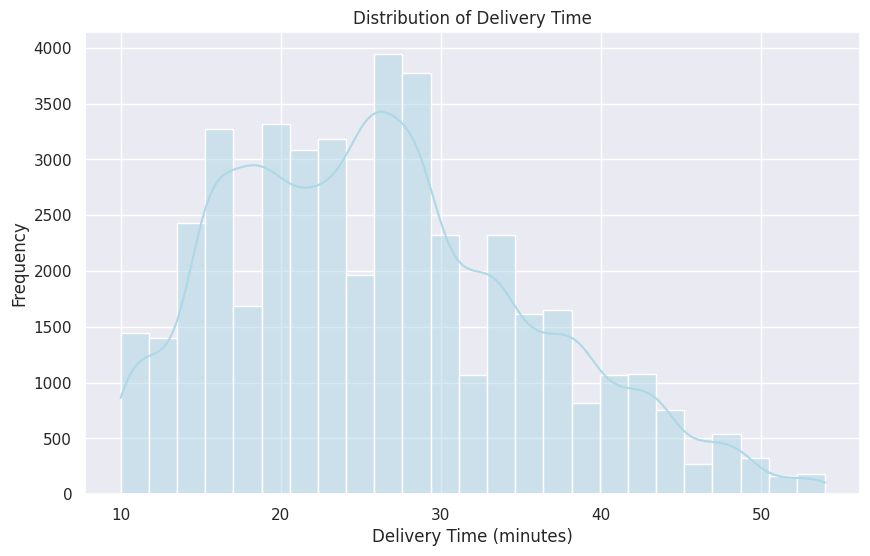

In [ ]:
# What is the typical delivery time range for orders, and how should we optimize our ETA estimates to improve customer experience?
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
sns.histplot(uber_cleaned_data['Time_taken(min)'], bins=25, kde=True, color='lightblue')
plt.title('Distribution of Delivery Time')
plt.xlabel('Delivery Time (minutes)')
plt.ylabel('Frequency')
plt.show()

Delivery Time Distribution:

The delivery times mostly range between 15 and 35 minutes, with a peak around 27-28 minutes.

Very few deliveries take longer than 45 minutes, and very few are completed in under 12 minutes.


Business Insight:

Since the bulk of deliveries cluster around 25-30 minutes, Uber could market this as a typical delivery time to set realistic customer expectations and improve satisfaction.

Optimize outliers: The long-tail delays (above 45 minutes) suggest operational inefficiencies or outlier cases—targeting these for improvement could enhance overall service reliability.

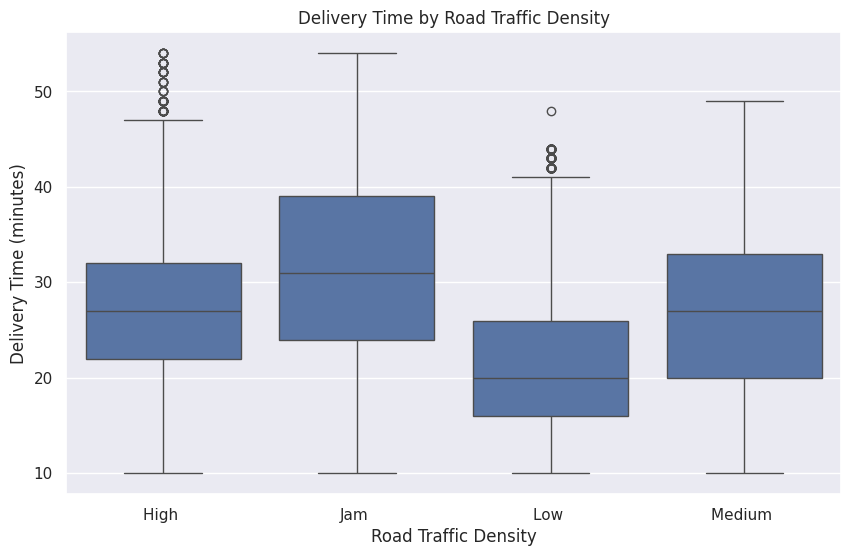

In [ ]:
# How does road traffic impact delivery times, and how can we optimize routing and dispatch strategies to reduce delays?

sns.set(style='darkgrid')
plt.figure(figsize=(10, 6))
sns.boxplot(x='Road_traffic_density', y='Time_taken(min)', data=uber_cleaned_data)
plt.title('Delivery Time by Road Traffic Density')
plt.xlabel('Road Traffic Density')
plt.ylabel('Delivery Time (minutes)')
plt.show()

In [ ]:
# Replace 'NaN ' (string) with actual NaN values
uber_cleaned_data['Road_traffic_density'] = uber_cleaned_data['Road_traffic_density'].replace('NaN ', pd.NA)

# Fill missing traffic density with the most frequent value
# since its a Categorical column → Mode imputation.
most_frequent_traffic = uber_cleaned_data['Road_traffic_density'].mode()[0]
uber_cleaned_data['Road_traffic_density'].fillna(most_frequent_traffic, inplace=True)

/tmp/ipython-input-1171689033.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  uber_cleaned_data['Road_traffic_density'].fillna(most_frequent_traffic, inplace=True)


/tmp/ipython-input-126841289.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Road_traffic_density', y='Time_taken(min)', data=uber_cleaned_data, palette='pastel')


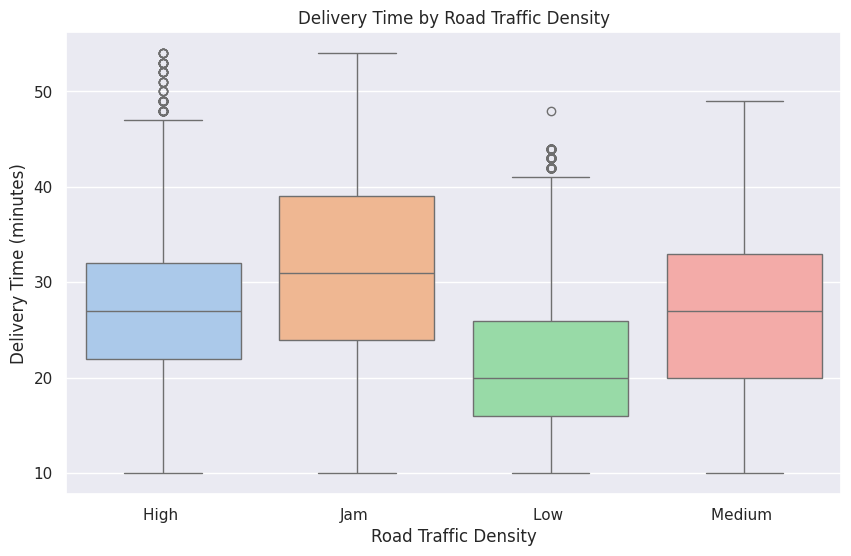

In [ ]:
sns.set(style='darkgrid')
plt.figure(figsize=(10, 6))
sns.boxplot(x='Road_traffic_density', y='Time_taken(min)', data=uber_cleaned_data, palette='pastel')
plt.title('Delivery Time by Road Traffic Density')
plt.xlabel('Road Traffic Density')
plt.ylabel('Delivery Time (minutes)')
plt.show()

Delivery Time vs Road Traffic:

High and jammed traffic leads to significantly longer deliveries
Low traffic = tighter, more predictable delivery windows

Business Insight:

Use traffic data in real-time routing
Prioritize dispatch during low/medium traffic hours

/tmp/ipython-input-1901780010.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Weatherconditions', y='Time_taken(min)', data=uber_cleaned_data, palette='Set2')


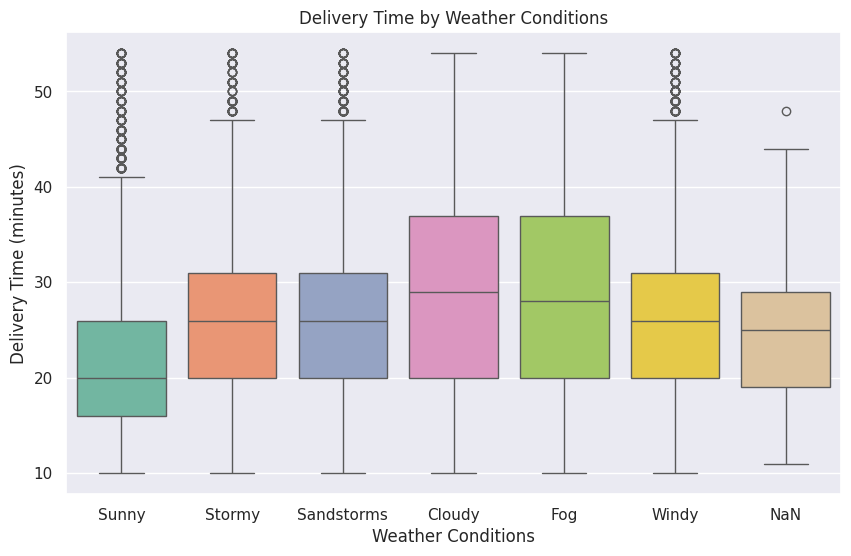

In [ ]:
# How does weather impact delivery times, and what strategies can be implemented to minimize delays and ensure reliable service?

sns.set(style='darkgrid')
plt.figure(figsize= (10,6))
sns.boxplot(x='Weatherconditions', y='Time_taken(min)', data=uber_cleaned_data, palette='Set2')
plt.title('Delivery Time by Weather Conditions')
plt.xlabel('Weather Conditions')
plt.ylabel('Delivery Time (minutes)')
plt.show()


In [ ]:
# we have NaN for weatherconditions so we fill them with NA
uber_cleaned_data['Weatherconditions'] = uber_cleaned_data['Weatherconditions'].replace('NaN', pd.NA)

most_frequent_condition = uber_cleaned_data['Weatherconditions'].mode()[0]
uber_cleaned_data['Weatherconditions'].fillna(most_frequent_condition,inplace=True)

/tmp/ipython-input-278851884.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  uber_cleaned_data['Weatherconditions'].fillna(most_frequent_condition,inplace=True)


/tmp/ipython-input-4018100662.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Weatherconditions', y='Time_taken(min)', data=uber_cleaned_data, palette='Set2')


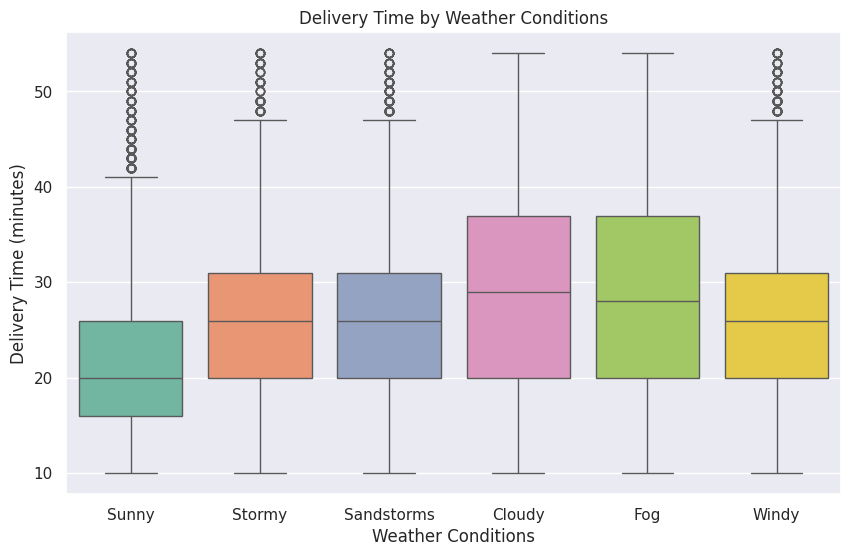

In [ ]:
sns.set(style='darkgrid')
plt.figure(figsize= (10,6))
sns.boxplot(x='Weatherconditions', y='Time_taken(min)', data=uber_cleaned_data, palette='Set2')
plt.title('Delivery Time by Weather Conditions')
plt.xlabel('Weather Conditions')
plt.ylabel('Delivery Time (minutes)')
plt.show()


Delivery Time vs Weather:

Cloudy & Foggy conditions cause more delay, unpredictable

Sunny days are faster and consistent(tight range), stormy and sandstorms are approx. 25min slightly slower and has more spread


Business Insight:

Dynamic ETAs & delivery incentives during bad weather.

Weather-aware scheduling of top drivers

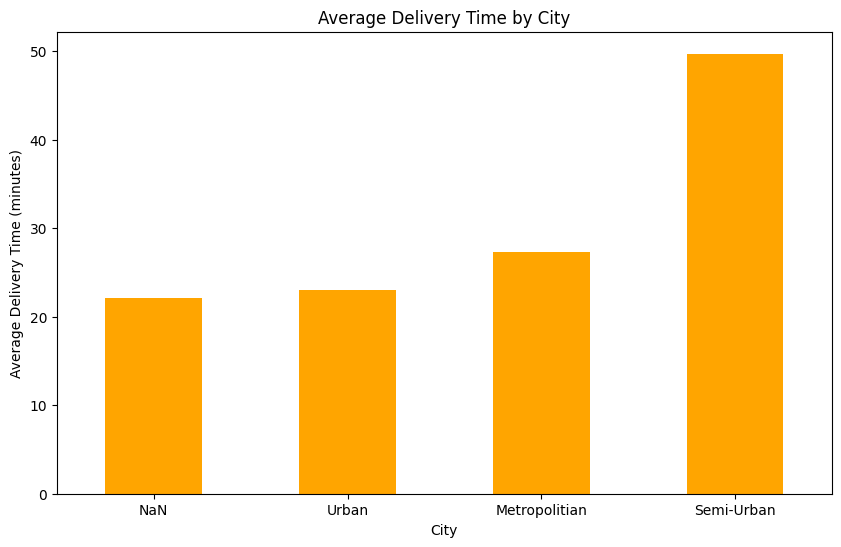

In [ ]:
# How does delivery time vary across different cities, and what strategies can optimize logistics in high-delay areas?

plt.figure(figsize=(10,6))
city_averages = uber_cleaned_data.groupby('City')['Time_taken(min)'].mean().sort_values()
city_averages.plot(kind='bar', color='orange')
plt.title('Average Delivery Time by City')
plt.xlabel('City')
plt.xticks(rotation=0)
plt.ylabel('Average Delivery Time (minutes)')
plt.show()

In [ ]:
uber_cleaned_data['City'] = uber_cleaned_data['City'].replace('NaN', pd.NA)

most_frequent_city = uber_cleaned_data['City'].mode()[0]
uber_cleaned_data['City'].fillna(most_frequent_city,inplace=True)

/tmp/ipython-input-3026526718.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  uber_cleaned_data['City'].fillna(most_frequent_city,inplace=True)


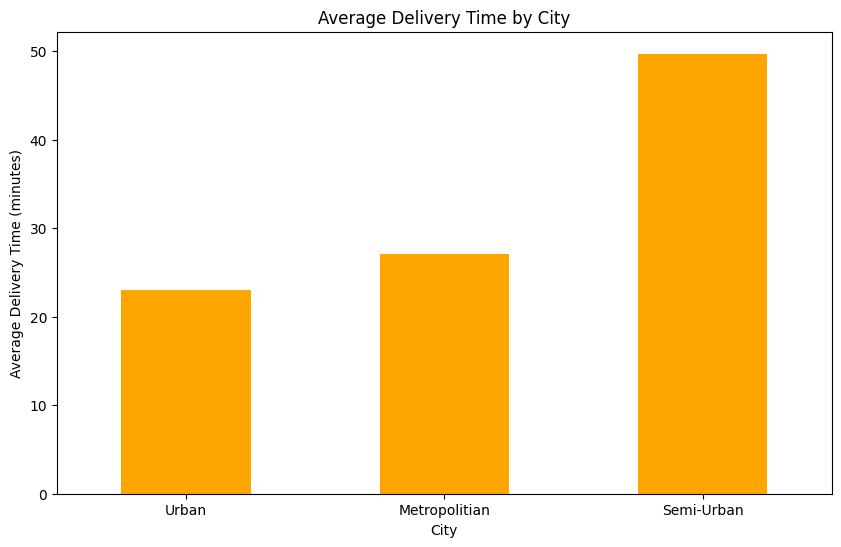

In [ ]:
plt.figure(figsize=(10,6))
city_averages = uber_cleaned_data.groupby('City')['Time_taken(min)'].mean().sort_values()
city_averages.plot(kind='bar', color='orange')
plt.title('Average Delivery Time by City')
plt.xlabel('City')
plt.xticks(rotation=0)
plt.ylabel('Average Delivery Time (minutes)')
plt.show()

Average Delivery Time by City:

Some cities (e.g., Metropolitan) have higher averages

Others (e.g., Urban or Semi-Urban) are faster

Business Insight:

Geo-segmented performance benchmarking

Improve logistics in underperforming cities

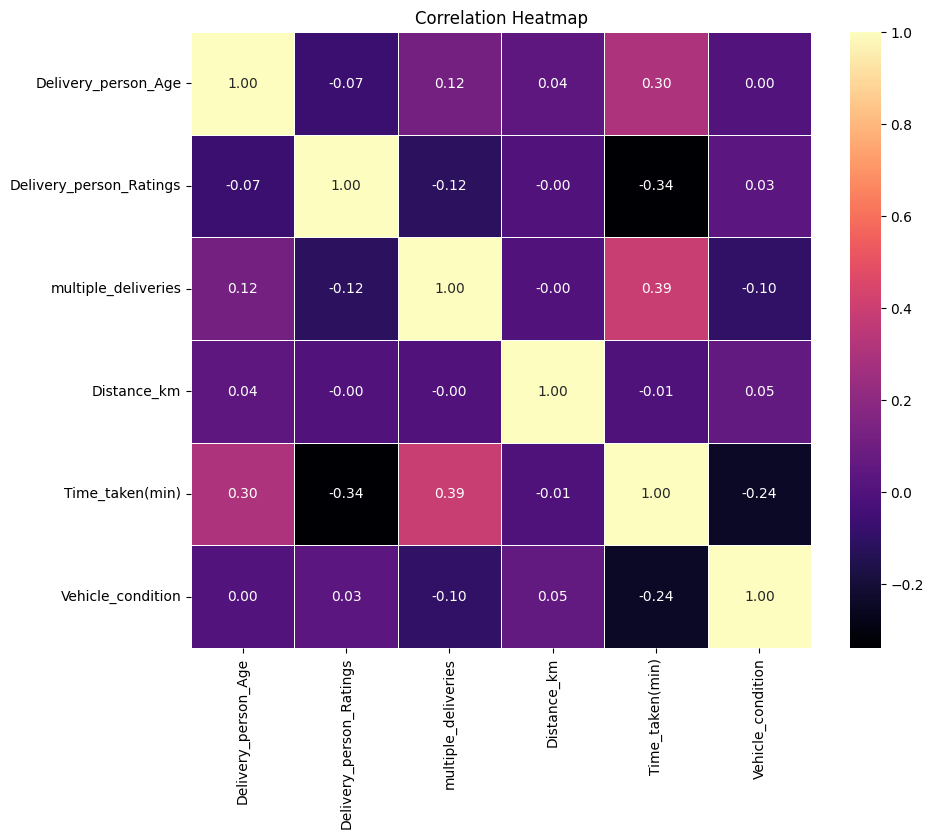

In [ ]:
# Select relevant numeric columns for correlation analysis

numeric_columns = ['Delivery_person_Age',
                   'Delivery_person_Ratings',
                   'multiple_deliveries',
                   'Distance_km',
                   'Time_taken(min)',
                   'Vehicle_condition']

correlation_matrix = uber_cleaned_data[numeric_columns].corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='magma', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()



Key Correlations:

1. Delivery_person_Age -> Time_taken(min) (0.30, moderate positive)
Older delivery persons tend to take slightly more time.
May indicate experience differences or driving habits (cautious vs fast).
2. Delivery_person_Ratings -> Time_taken(min) (-0.34, moderate negative)
Higher-rated drivers deliver faster.
Ratings may reflect punctuality and efficiency.
3. Multiple_deliveries -> Time_taken(min) (0.39, moderate positive)
More deliveries in a single trip increases delivery time.
Operational efficiency vs. customer satisfaction trade-off.
4. Vehicle_condition -> Time_taken(min) (-0.24, weak negative)
Better-conditioned vehicles slightly reduce delivery time.
Poor vehicles may cause delays (breakdowns, slow speed).
5. Distance_km -> Time_taken(min) (-0.01, negligible)
Surprisingly, almost no correlation.
Could mean distance is adjusted by route efficiency (traffic, clustering).

In [ ]:
# numeric_features = ['Delivery_person_Age',
#                    'Delivery_person_Ratings',
#                    'multiple_deliveries',
#                    'Distance_km',
#                    'Time_taken(min)',
#                    'Vehicle_condition']
# uber_cleaned_data[numeric_features] = uber_cleaned_data[numeric_features].replace(['NaN', ' ', '', 0], pd.NA)
# #

**Predictive Analysis with Delivery Times**

In [ ]:
# 1. importing neccesaary Libraries
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error ,r2_score

# 2. Selecting numeric features only
numeric_features = ['Delivery_person_Age',
                   'Delivery_person_Ratings',
                   'multiple_deliveries',
                   'Distance_km',
                   'Vehicle_condition']

target = 'Time_taken(min)'

# 3. Prepare X and y using the cleaned data from previous steps
X_features = uber_cleaned_data[numeric_features]
y_target = uber_cleaned_data[target]


# 4. Train and Test split
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.2, random_state = 42)

# 5. Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# 6. Make predictions on Test data
y_pred = model.predict(X_test)

# 7. Checking for accuracy
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print('Simple Linear Regression')
print(f"Mean Absolute Error: {mae:.2f} min")
print(f"Root Mean Squared Error: {rmse:.2f} min")
print(f"R-Squared:{r2:.2f}")

Simple Linear Regression
Mean Absolute Error: 6.14 min
Root Mean Squared Error: 7.73 min
R-Squared:0.33


In [ ]:
print(uber_cleaned_data['multiple_deliveries'].value_counts(dropna=False))

Series([], Name: count, dtype: int64)


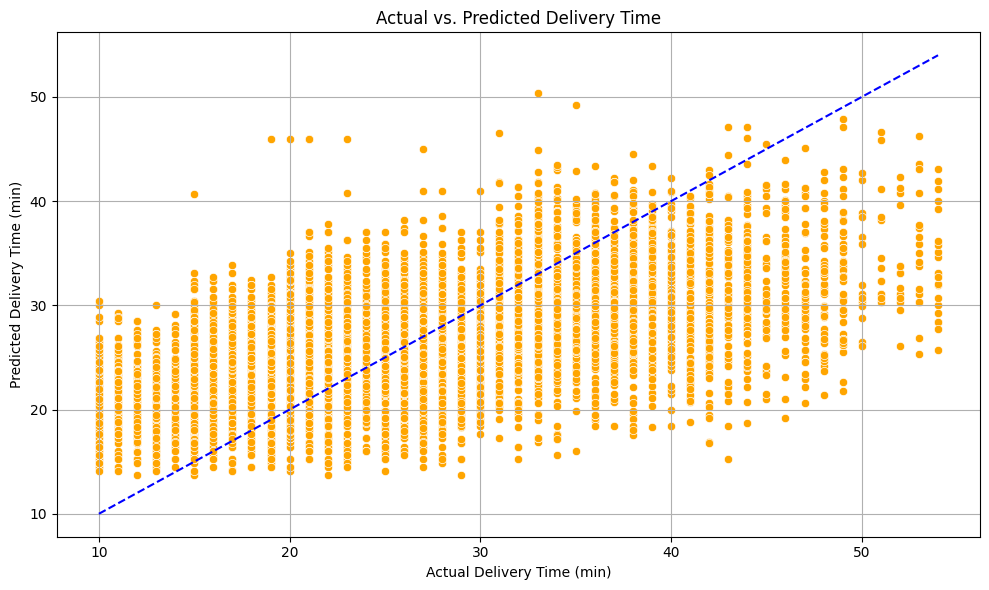

In [ ]:
# plot predicted vs actual delivery time
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_test, y=y_pred, color='orange')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='blue', linestyle='--')
plt.xlabel('Actual Delivery Time (min)')
plt.ylabel('Predicted Delivery Time (min)')
plt.title('Actual vs. Predicted Delivery Time')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# one hot encoding method - converts the categorical data into numbers assigning values to their own types for machine learning to predict
# using better that is random forest - collection of decision trees (decision or final answer based on input features yes or no)

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# 1. numeric + categorical features

n_features = ['Delivery_person_Age',
              'Delivery_person_Ratings',
              'multiple_deliveries',
              'Distance_km',
              'Vehicle_condition']

c_features = ['Road_traffic_density',
      'Weatherconditions',
      'Type_of_order',
      'Type_of_vehicle',
      'City',
      'Festival']

all_features = n_features + c_features

# 2. once again check and drop for na
model_data = uber_cleaned_data[all_features + [target]].dropna()

# 3. Prepare X and y using the cleaned data from previous steps
X_features = uber_cleaned_data[all_features]
y_target = uber_cleaned_data[target]

# 4. split into train and test
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.2, random_state = 42)

# 5. One hot encoding
preprocessor = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown='ignore'), c_features)
], remainder = 'passthrough')

# 6. random forest pipeline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

# 7. train the model
rf_pipeline.fit(X_train, y_train)




/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Road_traffic_density',
                                                   'Weatherconditions',
                                                   'Type_of_order',
                                                   'Type_of_vehicle', 'City',
                                                   'Festival'])])),
                ('model', RandomForestRegressor(random_state=42))])

In [ ]:
# 7. predictions
rf_pred = rf_pipeline.predict(X_test)

# 8. checking for accuracy
mse = mean_squared_error(y_test, rf_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, rf_pred)
r2 = r2_score(y_test, rf_pred)

print('Random Forest Regression')
print(f"Mean Absolute Error: {mae:.2f} min")
print(f"Root Mean Squared Error: {rmse:.2f} min")
print(f"R-Squared:{r2:.2f}")

Random Forest Regression
Mean Absolute Error: 3.14 min
Root Mean Squared Error: 3.93 min
R-Squared:0.83


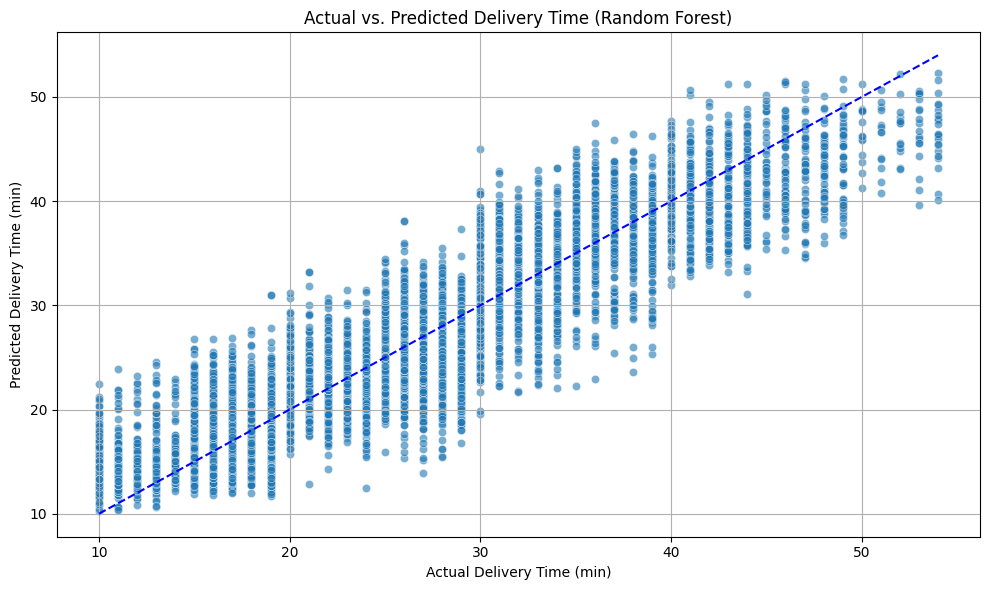

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_test, y=rf_pred, alpha=0.6, edgecolor='w')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='blue', linestyle='--')
plt.xlabel('Actual Delivery Time (min)')
plt.ylabel('Predicted Delivery Time (min)')
plt.title('Actual vs. Predicted Delivery Time (Random Forest)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# bringing in more advanced model - gradient boosting (add on to random forest model
# which simply penalizes more mistakes, as it works more on mistakes pushes the model towards not making any mistakes) to see if we get better accuracy

from sklearn.ensemble import GradientBoostingRegressor
gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(n_estimators = 100, learning_rate = 0.1, random_state = 42))
])

# feed the model
gb_pipeline.fit(X_train, y_train)



/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Road_traffic_density',
                                                   'Weatherconditions',
                                                   'Type_of_order',
                                                   'Type_of_vehicle', 'City',
                                                   'Festival'])])),
                ('model', GradientBoostingRegressor(random_state=42))])

In [ ]:
# predictions
gb_pred = gb_pipeline.predict(X_test)

# evaluate
mse = mean_squared_error(y_test, gb_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, gb_pred)

print('Gradient Boosting Regression')
print(f"Mean Absolute Error: {mae:.2f} min")
print(f"Root Mean Squared Error: {rmse:.2f} min")
print(f"R-Squared:{r2:.2f}")

# accuracy is same but the values have increase slightly, as its advanced more it might have gone into more thinking and almost gone into over thinking -
# so their might be bad decisions and an over kill

Gradient Boosting Regression
Mean Absolute Error: 3.47 min
Root Mean Squared Error: 4.32 min
R-Squared:0.83


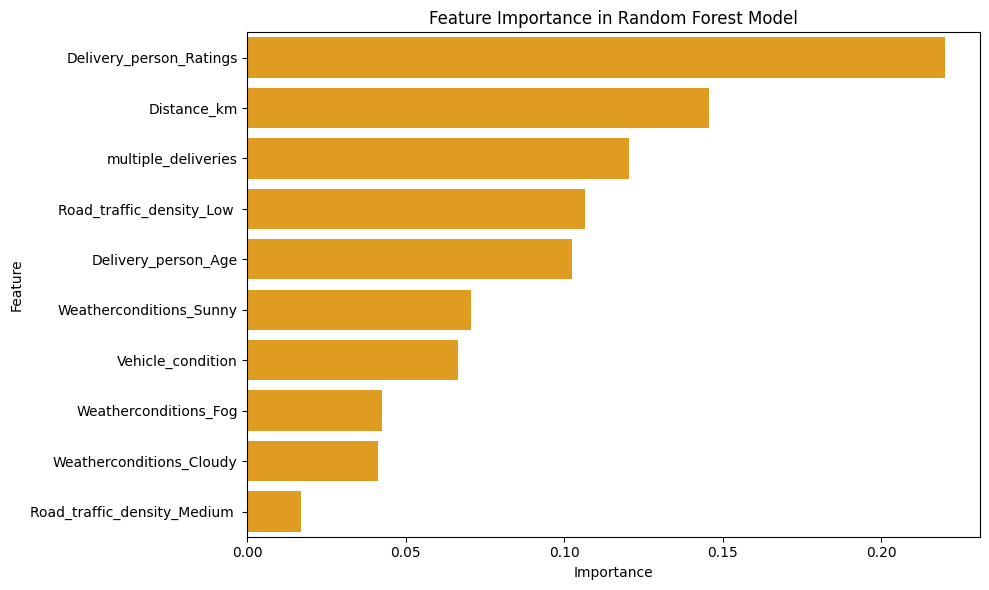

In [ ]:
# as correlation matrix gives a linear relationship between time taken and other factors as linearly the isnot fitting well so going for better model
# but random forest will be able to find non-linear relationship between all the factors/columns

# access the trained rf model from pipeline
rf_model = rf_pipeline.named_steps['model']

# get the feature names after encoding numbers back to names
encoded_features = preprocessor.named_transformers_['onehot'].get_feature_names_out(c_features)
all_feature_names = list(encoded_features) + n_features

# Get importances
importances = rf_model.feature_importances_

# Create DataFrame
importances_Df = pd.DataFrame(
    {'Feature': all_feature_names, 'Importance': importances}
).sort_values(by='Importance', ascending=False).head(10)

# plot
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importances_Df, color='orange')
plt.title('Feature Importance in Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()